<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#¿Qué-es-una-Serie-Temporal?" data-toc-modified-id="¿Qué-es-una-Serie-Temporal?-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>¿Qué es una Serie Temporal?</a></span></li><li><span><a href="#Exploración-de-los-datos" data-toc-modified-id="Exploración-de-los-datos-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Exploración de los datos</a></span><ul class="toc-item"><li><span><a href="#Conversión-de-la-columna-date-a-datetime" data-toc-modified-id="Conversión-de-la-columna-date-a-datetime-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Conversión de la columna date a datetime</a></span></li><li><span><a href="#Chequeemos-los-nulos." data-toc-modified-id="Chequeemos-los-nulos.-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Chequeemos los nulos.</a></span></li></ul></li><li><span><a href="#Componentes-de-una-Serie-Temporal" data-toc-modified-id="Componentes-de-una-Serie-Temporal-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Componentes de una Serie Temporal</a></span><ul class="toc-item"><li><span><a href="#Estacionalidad" data-toc-modified-id="Estacionalidad-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Estacionalidad</a></span></li><li><span><a href="#Estacionaridad" data-toc-modified-id="Estacionaridad-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Estacionaridad</a></span></li><li><span><a href="#Comparativa-estacionalidad-vs-estacionaridad" data-toc-modified-id="Comparativa-estacionalidad-vs-estacionaridad-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Comparativa estacionalidad vs estacionaridad</a></span></li></ul></li><li><span><a href="#Autocorrelación" data-toc-modified-id="Autocorrelación-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Autocorrelación</a></span></li><li><span><a href="#Modelo-ARIMA" data-toc-modified-id="Modelo-ARIMA-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Modelo ARIMA</a></span></li></ul></div>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from tqdm import tqdm

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]


## Para sacar los componentes de la serie temporal
################################################################
from statsmodels.tsa.seasonal import seasonal_decompose


## Para calcular la estacionaridad de nuestras series temporales
################################################################
from statsmodels.tsa.stattools import adfuller

## Para calcular la autocorrelación en la serie temporal
################################################################
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

## Para ajustar los modelos predictivos
################################################################
from statsmodels.tsa.arima.model import ARIMA
from itertools import product

## Para las metricas del modelo
################################################################
from sklearn.metrics import mean_squared_error

## Para ignorar los warnings
################################################################
import warnings
warnings.filterwarnings("ignore")

In [2]:
#!pip install statsmodels

# ¿Qué es una Serie Temporal?

Una Serie Temporal, es una sucesión de datos medidos en determinados momentos y ordenados cronológicamente. Los datos pueden estar espaciados a intervalos iguales (como la temperatura en un observatorio meteorológico en días sucesivos al mediodía) o desiguales (como el peso de una persona en sucesivas mediciones en el consultorio médico, la farmacia, etc.).

Cuando estamos trabajando con Series Temporales nos tenemos que hacer las siguientes preguntas: 

- ¿Es estacionario?

- ¿Hay una estacionalidad?

- ¿Los datos están autocorrelacionados?

# Exploración de los datos

In [3]:
df = pd.read_csv("data/caramelos.csv", index_col = 0)
df.head()

,date,IPG3113N
0,1972-01-01,85.598809
1,1972-02-01,71.741404
2,1972-03-01,65.948809
3,1972-04-01,64.490724
4,1972-05-01,64.933842


## Conversión de la columna date a datetime
Para trabajar con Series Temporales debemos asegurarnos de que la columna de fecha esta en formato `datetime`, que este como índice y debe tener alguna frecuencia. Veamos como hacerlo: 

In [4]:
df.index = pd.to_datetime(df["date"])
df.head()

,date,IPG3113N
date,,
1972-01-01,1972-01-01,85.598809
1972-02-01,1972-02-01,71.741404
1972-03-01,1972-03-01,65.948809
1972-04-01,1972-04-01,64.490724
1972-05-01,1972-05-01,64.933842


Si nos fijamos nuestra columna de momento no tiene frecuencia. Para cambiarlo usaremos el método `infer_freq` de pandas

In [5]:
df.index.freq = pd.infer_freq(df.index)
df.index

DatetimeIndex(['1972-01-01', '1972-02-01', '1972-03-01', '1972-04-01',
               '1972-05-01', '1972-06-01', '1972-07-01', '1972-08-01',
               '1972-09-01', '1972-10-01',
               ...
               '2018-03-01', '2018-04-01', '2018-05-01', '2018-06-01',
               '2018-07-01', '2018-08-01', '2018-09-01', '2018-10-01',
               '2018-11-01', '2018-12-01'],
              dtype='datetime64[ns]', name='date', length=564, freq='MS')

In [6]:
df.drop(columns=['date'], inplace=True)
df.head()

,IPG3113N
date,
1972-01-01,85.598809
1972-02-01,71.741404
1972-03-01,65.948809
1972-04-01,64.490724
1972-05-01,64.933842


Si nos fijamos ahora Pandas automaticamente ha detectado la frecuencia, es de día. 

In [7]:
df.columns = ["valores"]
df.head()

,valores
date,
1972-01-01,85.598809
1972-02-01,71.741404
1972-03-01,65.948809
1972-04-01,64.490724
1972-05-01,64.933842


## Chequeemos los nulos. 

🚨🚨🚨 No podremos tenere nulos en el *dataframe*

# Componentes de una Serie Temporal

El análisis clásico de series temporales considera que una serie temporal queda formada por cuatro
componentes:

- `Tendencia o Estacionaridad`: movimiento regular de la serie, a largo plazo.


- `Variaciones estacionales`: oscilaciones a corto plazo del período regular, de duración menor o igual a un año.


- `Variaciones cíclicas`: movimientos a medio plazo (superior a un año) en torno a la tendencia cuyo período y amplitud pueden presentar cierta regularidad.


- `Ruido Blanco o residuos`: consisten en movimientos irregulares y pasajeros provocados por factores esporádicos e imprevisibles. Son efectos impredecibles que no son asignables a ninguna de las componentes anteriores, por lo que constituyen el residuo que queda cuando se estiman las otras componentes.

In [8]:
df2 = df.copy()
df2.head()

,valores
date,
1972-01-01,85.598809
1972-02-01,71.741404
1972-03-01,65.948809
1972-04-01,64.490724
1972-05-01,64.933842


In [9]:
df2["year"] = df2.index.year
df2["month"] = df2.index.month
df2.head()

,valores,year,month
date,,,
1972-01-01,85.598809,1972,1
1972-02-01,71.741404,1972,2
1972-03-01,65.948809,1972,3
1972-04-01,64.490724,1972,4
1972-05-01,64.933842,1972,5


## Estacionalidad


Un patrón estacional se produce cuando una serie temporal se ve afectada por factores estacionales, como la época del año o el día de la semana. La estacionalidad tiene siempre una frecuencia fija y conocida.



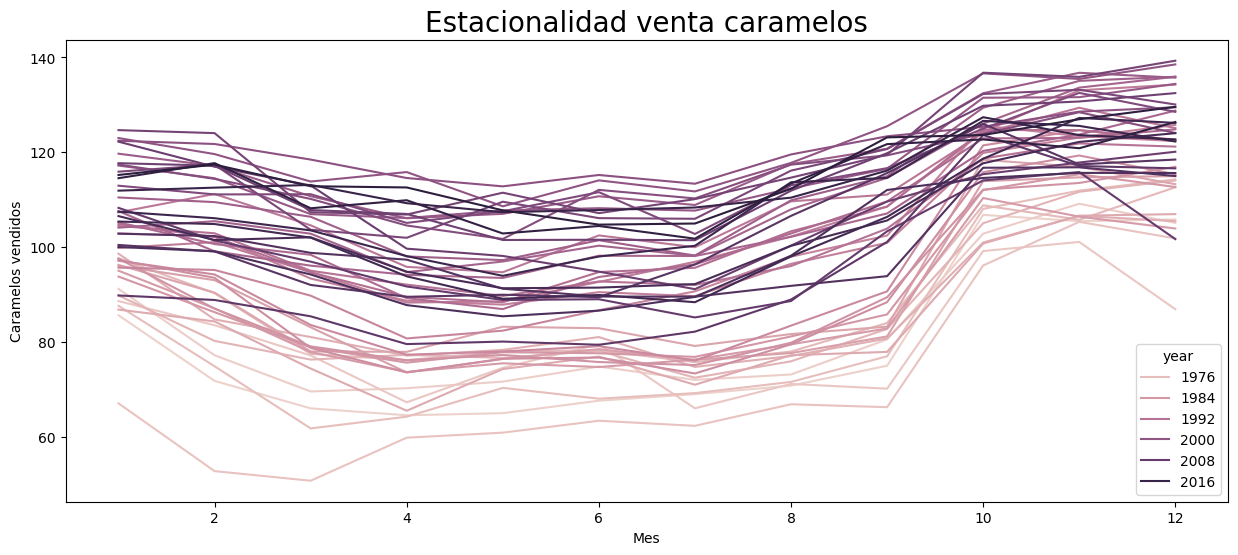

In [12]:
fig, ax = plt.subplots(figsize=(15, 6))

sns.lineplot(x = 'month', y = 'valores', data = df2, hue=df2['year'])
ax.set_title('Estacionalidad venta caramelos', fontsize = 20, loc='center')
ax.set_xlabel('Mes')
ax.set_ylabel('Caramelos vendidos');

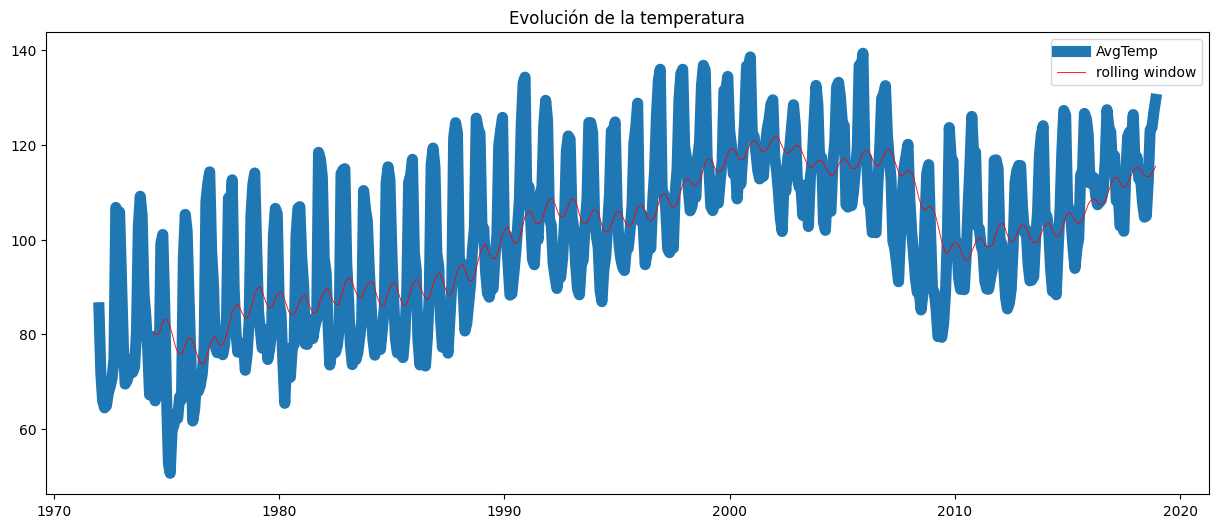

In [11]:
plt.figure(figsize=(15,6))
plt.title("Evolución de la temperatura")

plt.plot(df["valores"], label="AvgTemp", linewidth=8)
plt.plot(df.rolling(window =30).mean(), label="rolling window", c= "r", linewidth = 0.6)

plt.legend();

In [14]:
res_ad = adfuller(df["valores"])
res_ad

(-1.776015307501608,
 0.3924327500714014,
 14,
 549,
 {'1%': -3.4423174665535385,
  '5%': -2.866818952732754,
  '10%': -2.569581505602171},
 3094.828881317046)

In [15]:
# pongamosle etiquetas a los resultados
print('ADF Statistic:', res_ad[0])
print('p-value:', res_ad[1])
print('Critical Values:')
for key, value in res_ad[4].items():
    print( "\t",  key, round(value, 2))


ADF Statistic: -1.776015307501608
p-value: 0.3924327500714014
Critical Values:
	 1% -3.44
	 5% -2.87
	 10% -2.57


**¿Cuáles son las conclusiones de esta prueba?**

A partir de los resultados del test de Dickey Fuller podemos observar dos cosas:

- Si adf > valores_críticos  ==> DATOS NO ESTACIONARIOS


- pvalue> 0.05  ==> DATOS NO ESTACIONARIOS


Nuestro datos son no estacionarios.

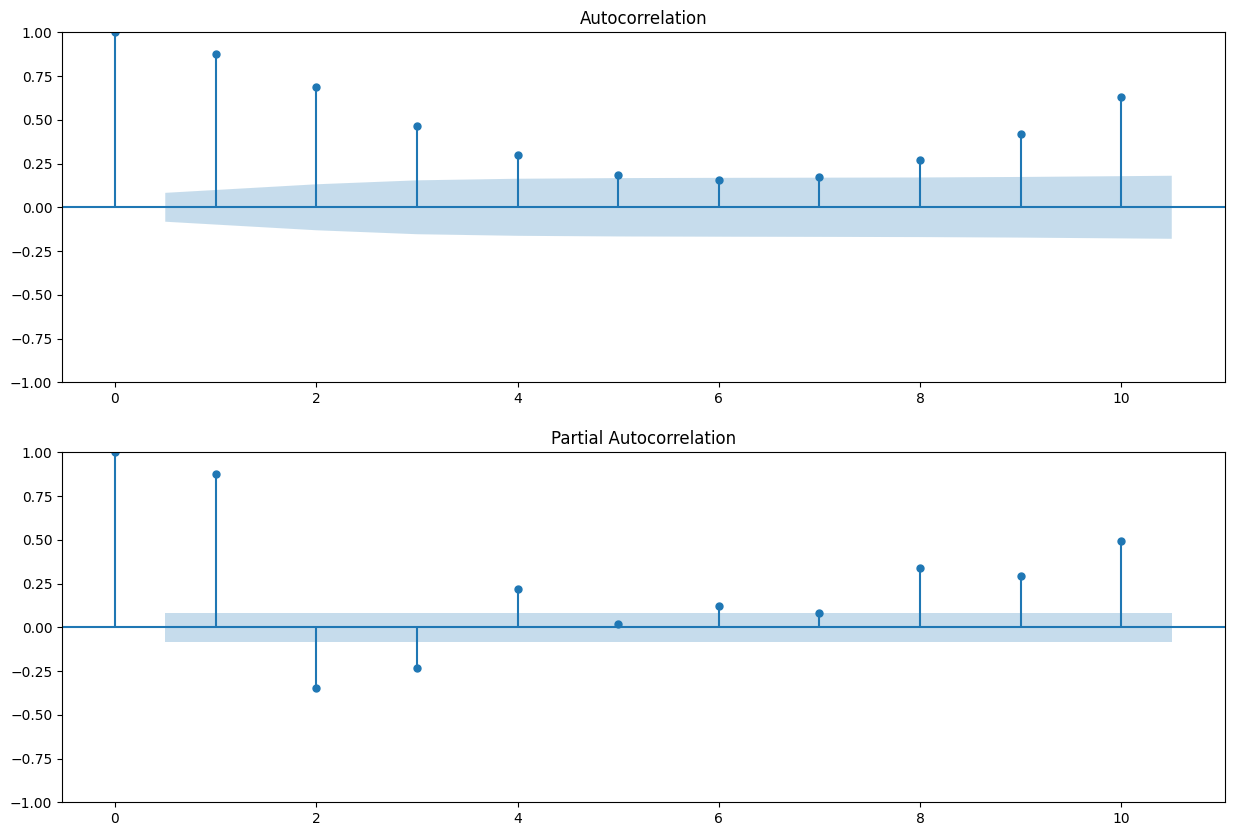

In [26]:

fig, axes = plt.subplots(2, 1, figsize=(15,10))
plot_acf(df, lags=10, ax= axes[0])
plot_pacf(df, lags=10, ax= axes[1]);

# Modelo ARIMA

ARIMA (*AutoRegresive Integrated Moving Average*), deriva de sus tres componentes 

- `Autorregresivo(AR)`: la variable dependiente depende de sí misma en un período de tiempo t. **Será la `p` y lo sacaremos de la gráfica de autocorrelación**. En otras palabras, el modelo autorregresivo se basa en la idea de que la observación actual puede explicarse con valores pasados. Estos modelos se denotan como AR(p) siendo p el número de muestras que explican la muestra actual. Es decir, un AR(1) quiere decir que sólo la muestra anterior y el ruido contribuye a la salida. Un AR(2) las dos anteriores y el ruido, etc. 



- `Integrado(I)`: es el número de diferencias no estacionales **los valores normalmente no deben ser más de dos por norma general**, es decir, se trata del número de diferencias en unidades de tiempo necesarias para obtener la estacionarieda. Este parámetro se corresponde con el grado de la tendencia de la serie (la diferenciación de primer orden representa las tendencias lineales, la diferenciación de segundo orden representa las tendencias cuadráticas, etc.).

- `Media móvil(MA)`: los retrocesos son representados por procesos aleatorios. **Será la `q` y lo sacaremos de la gráfica de autocorrelación parcial**. Es decir, consiste en realizar una aproximación a la serie utilizando únicamente ruido blanco.


Lo primero que tenemos que hacer es separar nuestros datos en *train* y *test*, para seguir con buenas prácticas y ver si nuestras predicciones están *overfiteadas* 

In [27]:
y_test = df["valores"][-30:]
y_train = df["valores"][:-30]

In [28]:
ps = range(7)
ds = range(1,3)
qs = range(6)

parameters = list(product(ps,ds, qs))
print(parameters)

[(0, 1, 0), (0, 1, 1), (0, 1, 2), (0, 1, 3), (0, 1, 4), (0, 1, 5), (0, 2, 0), (0, 2, 1), (0, 2, 2), (0, 2, 3), (0, 2, 4), (0, 2, 5), (1, 1, 0), (1, 1, 1), (1, 1, 2), (1, 1, 3), (1, 1, 4), (1, 1, 5), (1, 2, 0), (1, 2, 1), (1, 2, 2), (1, 2, 3), (1, 2, 4), (1, 2, 5), (2, 1, 0), (2, 1, 1), (2, 1, 2), (2, 1, 3), (2, 1, 4), (2, 1, 5), (2, 2, 0), (2, 2, 1), (2, 2, 2), (2, 2, 3), (2, 2, 4), (2, 2, 5), (3, 1, 0), (3, 1, 1), (3, 1, 2), (3, 1, 3), (3, 1, 4), (3, 1, 5), (3, 2, 0), (3, 2, 1), (3, 2, 2), (3, 2, 3), (3, 2, 4), (3, 2, 5), (4, 1, 0), (4, 1, 1), (4, 1, 2), (4, 1, 3), (4, 1, 4), (4, 1, 5), (4, 2, 0), (4, 2, 1), (4, 2, 2), (4, 2, 3), (4, 2, 4), (4, 2, 5), (5, 1, 0), (5, 1, 1), (5, 1, 2), (5, 1, 3), (5, 1, 4), (5, 1, 5), (5, 2, 0), (5, 2, 1), (5, 2, 2), (5, 2, 3), (5, 2, 4), (5, 2, 5), (6, 1, 0), (6, 1, 1), (6, 1, 2), (6, 1, 3), (6, 1, 4), (6, 1, 5), (6, 2, 0), (6, 2, 1), (6, 2, 2), (6, 2, 3), (6, 2, 4), (6, 2, 5)]


In [29]:
%%time
rmse = []
order = []
for p, d, q in tqdm(parameters):
    try:
        modelo=ARIMA(y_train, order=(p, d, q)).fit()
        pred = modelo.predict(start=len(y_train), end=len(df) -1)
        error = np.sqrt(np.mean(mean_squared_error(y_test, pred)))
        rmse.append(error)
        order.append((p,d, q))
    except: 
        continue

100%|███████████████████████████████████████████| 84/84 [00:18<00:00,  4.57it/s]

CPU times: user 1min 32s, sys: 7.85 s, total: 1min 40s
Wall time: 18.4 s


In [31]:
# veamos los resultados de todos los modelos
results = pd.DataFrame({"RMSE": rmse, "order": order})
results.sort_values(by="RMSE", inplace=True)
results.head()

,RMSE,order
53,3.904878,"(4, 1, 5)"
64,4.150829,"(5, 1, 5)"
41,4.324953,"(3, 1, 5)"
39,4.627370,"(3, 1, 3)"
27,4.638091,"(2, 1, 3)"


In [32]:
modelo=ARIMA(y_train, order=(4, 1, 5)).fit()
pred = pd.DataFrame(modelo.predict(start=len(y_train), end=len(df) -1))

In [33]:
pred["real_test"] = y_test


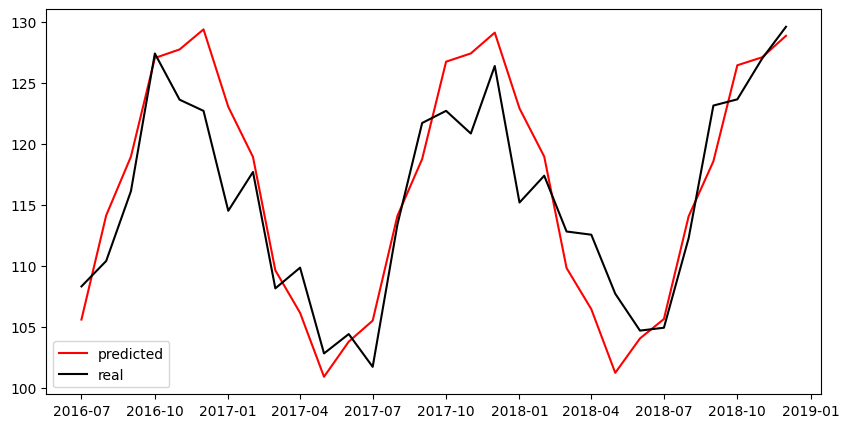

In [34]:
plt.plot(pred['predicted_mean'], c = "red")
plt.plot(pred["real_test"], c = "black")
plt.legend(["predicted", "real"]);

**Vamos a hacer predicciones más allá de los datos que tenemos, en concreto intentaremos predecir los siguientes doce meses**

Hagamos zoom sobre los ultimos meses de la gráfica